In [2]:
# Imports

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd


In [20]:
# Audio files are stored in the following directory:
# data/data_final/audios/Contr
# data/data_final/audios/FESS
# data/data_final/audios/Sept
# data/data_final/audios/Tonsill

# Get all .wav audios from all the directories
path_to_audios = 'data/data_final/Audios'
audios = []
for root, dirs, files in os.walk(path_to_audios):
    for name in files:
        if name.endswith('.wav'):
            audios.append(os.path.join(root, name))


In [21]:
# The following code will load the audio files:
def read_audio(path):
    y, sr = librosa.load(path, sr=44100)
    return y, sr

df = pd.DataFrame(columns=['audiopath','audio_raw','label'])
df['audiopath'] = audios
# Get SR and audio in two columns
df[['audio_raw', 'sr']] = df['audiopath'].apply(lambda x: pd.Series(read_audio(x)))
df['label'] = df['audiopath'].apply(lambda x: x.split('/')[3])

In [22]:
# Normalise the audios

def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

df['audio'] = df['audio_raw'].apply(lambda x: normalize_audio(x))

In [23]:
# Get a new column with the session number extracted from the audio path
df['session'] = df['audiopath'].apply(lambda x: x.split('/')[5])

In [24]:
# Drop all rows which have session aeiou, or concatenateread or tests
df = df[~df['session'].isin(['aeiou', 'concatenateread', 'tests'])]

In [25]:
# Calculate mfccs
def extract_mfcc_with_derivatives(
       audio, sample_rate, frame_length_ms, n_mfcc=10
    ):
        """
        Extracts Mel-frequency cepstral coefficients (MFCCs) with their first and second derivatives from an audio signal.

        Args:
            audio (np.ndarray): The audio signal as a 1D numpy array.
            sample_rate (int): The sample rate of the audio signal.
            frame_length_ms (float): The length of the frames in milliseconds.
            n_mfcc (int): The number of MFCCs to extract.

        Returns:
            np.ndarray: A 2D numpy array of shape (num_frames, num_features) containing the MFCCs and their derivatives.
        """
        frame_length = int(
            sample_rate * frame_length_ms * 1e-3
        )  # Convert ms to samples
        hop_length = int(frame_length / 2)  # 50% overlap
        frames = librosa.util.frame(
            audio, frame_length=frame_length, hop_length=hop_length
        )

        # Apply hanning windows
        frames = frames * np.hanning(frame_length)[:, None]

        # N_fft is the next number in power of 2 of the frame size
        n_fft = 2 ** (int(np.log2(frames.shape[1])) + 1)

        # Compute MFCC for each frame
        mfccs = []
        for frame in frames.T:
            mfcc = librosa.feature.mfcc(
                y=frame, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft
            )
            # Normalize the MFCCs
            mfccs.append(mfcc.T)

        mfccs = np.vstack(mfccs)

        # Normalize the MFCCs
        mfccs = (mfccs - np.mean(mfccs, axis=0)) / np.std(mfccs, axis=0)

        # Compute derivatives
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        # Concatenate the features
        mfcc_features = np.concatenate((mfccs, mfccs_delta, mfccs_delta2), axis=1)

        return mfcc_features

## COMPUTING MFCCS

Care, this requires time to compute. It took 11 min and 10.5 secs to compute in a computer with the following specs:

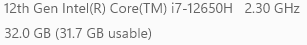

In [41]:
df_first_session = df[df['session'] == '1']

# Create a column named "Audio Material" which will contain the audio name wih is the [4] index of the path
df_first_session['Audio Material'] = df_first_session['audiopath'].apply(lambda x: x.split('/')[4])

/tmp/ipykernel_997/3674064886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_session['Audio Material'] = df_first_session['audiopath'].apply(lambda x: x.split('/')[4])


In [43]:
# Select only the "A" vowel from the first session
df_first_session = df_first_session[df_first_session['Audio Material'] == 'A3']

# Calculate the MFCCs for the first session
df_first_session["mfccs"] = df_first_session.apply(
                lambda x: extract_mfcc_with_derivatives(
                    x["audio"],
                    x["sr"],
                    40,
                    13,
                ),
                axis=1,
            )

/home/alexjorguer/miniconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [44]:
# Explode the mfccs column
df_first_session = df_first_session.explode('mfccs')


In [45]:
df_first_session

,audiopath,audio_raw,label,sr,audio,session,Audio Material,mfccs
493,data/data_final/Audios/Sept/A3/1/Sept_ses1_a3_...,"[0.0014343262, -0.0014953613, -0.004425049, -0...",Sept,44100,"[0.008212476, -0.008561943, -0.025336362, -0.0...",1,A3,"[-1.030343833955165, -0.005154313320571642, 1...."
493,data/data_final/Audios/Sept/A3/1/Sept_ses1_a3_...,"[0.0014343262, -0.0014953613, -0.004425049, -0...",Sept,44100,"[0.008212476, -0.008561943, -0.025336362, -0.0...",1,A3,"[0.8562518408556008, 0.1850353649052064, -0.89..."
493,data/data_final/Audios/Sept/A3/1/Sept_ses1_a3_...,"[0.0014343262, -0.0014953613, -0.004425049, -0...",Sept,44100,"[0.008212476, -0.008561943, -0.025336362, -0.0...",1,A3,"[1.3069059886249088, -0.8672618218556868, -1.3..."
493,data/data_final/Audios/Sept/A3/1/Sept_ses1_a3_...,"[0.0014343262, -0.0014953613, -0.004425049, -0...",Sept,44100,"[0.008212476, -0.008561943, -0.025336362, -0.0...",1,A3,"[-0.42522597290760933, 1.6368604098215747, 0.9..."
493,data/data_final/Audios/Sept/A3/1/Sept_ses1_a3_...,"[0.0014343262, -0.0014953613, -0.004425049, -0...",Sept,44100,"[0.008212476, -0.008561943, -0.025336362, -0.0...",1,A3,"[-0.07445987968237364, -0.6608084102119534, 1...."
...,...,...,...,...,...,...,...,...
4130,data/data_final/Audios/Fess/A3/1/FESS_ses1_a3_...,"[0.013397217, 0.010345459, 0.0064697266, 0.001...",Fess,44100,"[0.047655232, 0.036799826, 0.023013461, 0.0064...",1,A3,"[-0.410186168127654, 1.7215680596189311, -0.03..."
4130,data/data_final/Audios/Fess/A3/1/FESS_ses1_a3_...,"[0.013397217, 0.010345459, 0.0064697266, 0.001...",Fess,44100,"[0.047655232, 0.036799826, 0.023013461, 0.0064...",1,A3,"[-1.1908309473981986, -0.058525792132942296, 1..."
4130,data/data_final/Audios/Fess/A3/1/FESS_ses1_a3_...,"[0.013397217, 0.010345459, 0.0064697266, 0.001...",Fess,44100,"[0.047655232, 0.036799826, 0.023013461, 0.0064...",1,A3,"[0.5194339580312592, -0.5205214787103855, -0.6..."
4130,data/data_final/Audios/Fess/A3/1/FESS_ses1_a3_...,"[0.013397217, 0.010345459, 0.0064697266, 0.001...",Fess,44100,"[0.047655232, 0.036799826, 0.023013461, 0.0064...",1,A3,"[1.1514996669851312, -0.8139614468796627, -0.2..."


## Simple classifier

Let us generate a toy example where we want to distinguish control vs patients.

In [46]:
# First, get only the interesting columns: "mfccs", "label" and the index with is the id
df_toy = df_first_session[["mfccs", "label"]].reset_index()

In [47]:
# Index column is the patient identification, hence, split into train and test based on this column so the same patient is not in both
df_train = df_toy[df_toy["index"] % 2 == 0]
df_test = df_toy[df_toy["index"] % 2 == 1]

In [48]:
# Binarise the labels, "control" is 0 and all the othres are 1
df_train["label"] = df_train["label"].apply(lambda x: 0 if x == "Contr" else 1)
df_test["label"] = df_test["label"].apply(lambda x: 0 if x == "Contr" else 1)


/tmp/ipykernel_997/1673710798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = df_train["label"].apply(lambda x: 0 if x == "Contr" else 1)
/tmp/ipykernel_997/1673710798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = df_test["label"].apply(lambda x: 0 if x == "Contr" else 1)


In [49]:
# Print value counts for each label
print(df_train["label"].value_counts())

label
1    15464
0     4360
Name: count, dtype: int64


In [50]:
# Train a RandomForest model
from sklearn.ensemble import RandomForestClassifier

X_train = np.vstack(df_train["mfccs"].values)
y_train = df_train["label"].values

X_test = np.vstack(df_test["mfccs"].values)
y_test = df_test["label"].values

print("Training...")

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

print("Predicting...")

# Get the predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)



Training...
Predicting...


In [51]:
# Get the accuracy
from sklearn.metrics import accuracy_score
# print training accuracy
print("Training accuracy: ", accuracy_score(y_train, y_pred_train))
# print test accuracy
print("Test accuracy: ", accuracy_score(y_test, y_pred_test))

Training accuracy:  0.8328793381759484
Test accuracy:  0.7460881202388305


# KALMAN trajectories

The file .pkl containes the information needed to calculate the KALMAN trajectories and the trajectories themselves.

In [52]:
import pandas as pd
import pickle
import os


# Read all .pkl files under /data/data_final/Audios
path_to_audios = 'data/data_final/Audios'
audios = []
for root, dirs, files in os.walk(path_to_audios):
    for name in files:
        if name.endswith('.pkl'):
            audios.append(os.path.join(root, name))

# Read all the .pkl files
karma_structure = {"audio": None, 
           "Formants": {"F1": {"mean": None, "std": None, "bw": None}, 
                        "F2": {"mean": None, "std": None, "bw": None}, 
                        "F3": {"mean": None, "std": None, "bw": None}},
            "AntiFormants": {"AntiF1": {"mean": None, "std": None, "bw": None},
                            "AntiF2": {"mean": None, "std": None, "bw": None}},
        }

dict_keys(['F1', 'F2', 'F3'])
dict_keys(['mean', 'std', 'bw'])
dict_keys(['AntiF1', 'AntiF2'])
dict_keys(['peCoeff', 'windowType', 'windowSizems', 'windowOverlap', 'lpcOrder', 'zOrder', 'fs', 'cepOrder', 'cepType', 'algFlag'])


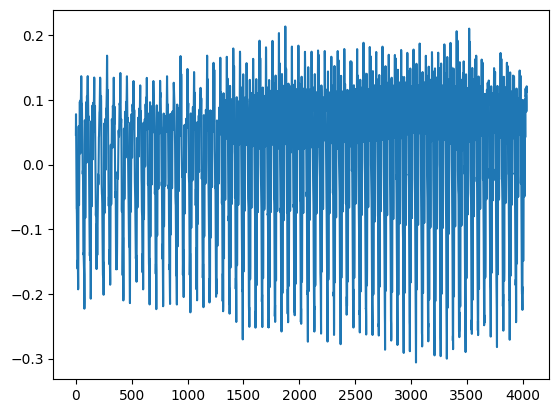

In [56]:
from matplotlib import pyplot as plt
# check one pkl
with open(audios[0], 'rb') as f:
    data = pickle.load(f)

# Access the normalised audio
audio = data['audio']

# plot it 
plt.plot(audio)

# Access the formants
formants = data['Formants']
print(formants.keys())

# acess the f1
f1 = formants['F1']
mean_f1 = f1['mean']
var_f1 = f1['std']**2
bw_f1 = f1['bw']
print(f1.keys())

# Access the anti-formants
antiformants = data['AntiFormants']
print(antiformants.keys())

# access the params
params = data['params']
print(params.keys())